In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

Above we import, below we define the basic ODE for modelling the system.

In [11]:
def sistema_dinamico(t, y, u, params):
    Sh, Ih, Rh, Sv, Iv = y
    Lambda_h, omega, mu_h, beta_h, xi1, q1, delta, rho, Lambda_v, mu_v, beta_v, xi2, q2 = params
    
    Nh = Sh + Ih + Rh
    Nv = Sv + Iv

    # Convertir 'u' a escalar si es necesario
    if np.isscalar(u) == False:
        u = u.item()  # Convierte 'u' a escalar si es un array de un elemento

    # Ecuaciones del sistema incluyendo el término de control 'u'
    dSh_dt = Lambda_h + omega * Rh - beta_h * Iv / Nh * Sh - mu_h * Sh
    dIh_dt = beta_h * Iv / Nh * Sh - (xi1 * (1 - q1) + u) * Ih - (delta + rho + mu_h) * Ih
    dRh_dt = (xi1 * (1 - q1) + u) * Ih + delta * Ih - (omega + mu_h) * Rh
    dSv_dt = Lambda_v - beta_v * Ih / Nh * Sv - (xi2 * (1 - q2) + u) * Sv - mu_v * Sv
    dIv_dt = beta_v * Ih / Nh * Sv - (xi2 * (1 - q2) + u) * Iv - mu_v * Iv

    return [dSh_dt, dIh_dt, dRh_dt, dSv_dt, dIv_dt]
def control_optimo(u, *args):
    T, initial_conditions, params = args
    result = solve_ivp(lambda t, y: sistema_dinamico(t, y, u, params), [0, T], initial_conditions, t_eval=np.linspace(0, T, 100))
    Ih = result.y[1]  # Infectados humanos
    coste = np.trapz(Ih**2 + u**2, result.t)  # Función de coste
    return coste
# Parámetros del modelo y condiciones iniciales
params = (1, 0.1, 0.01, 0.4, 0.7, 0.1, 0.05, 0.02, 0.5, 0.1, 0.3, 0.3, 0.05)
initial_conditions = [1000, 100, 50, 1000, 100]
T = 50  # Horizonte de tiempo


In [13]:
solucion = minimize(control_optimo, [0.1], args=(T, initial_conditions, params), method='BFGS')

print("Control óptimo encontrado:", solucion.x)
print("Coste mínimo:", solucion.fun)

Control óptimo encontrado: [2.66815868]
Coste mínimo: 3132.3161792678893


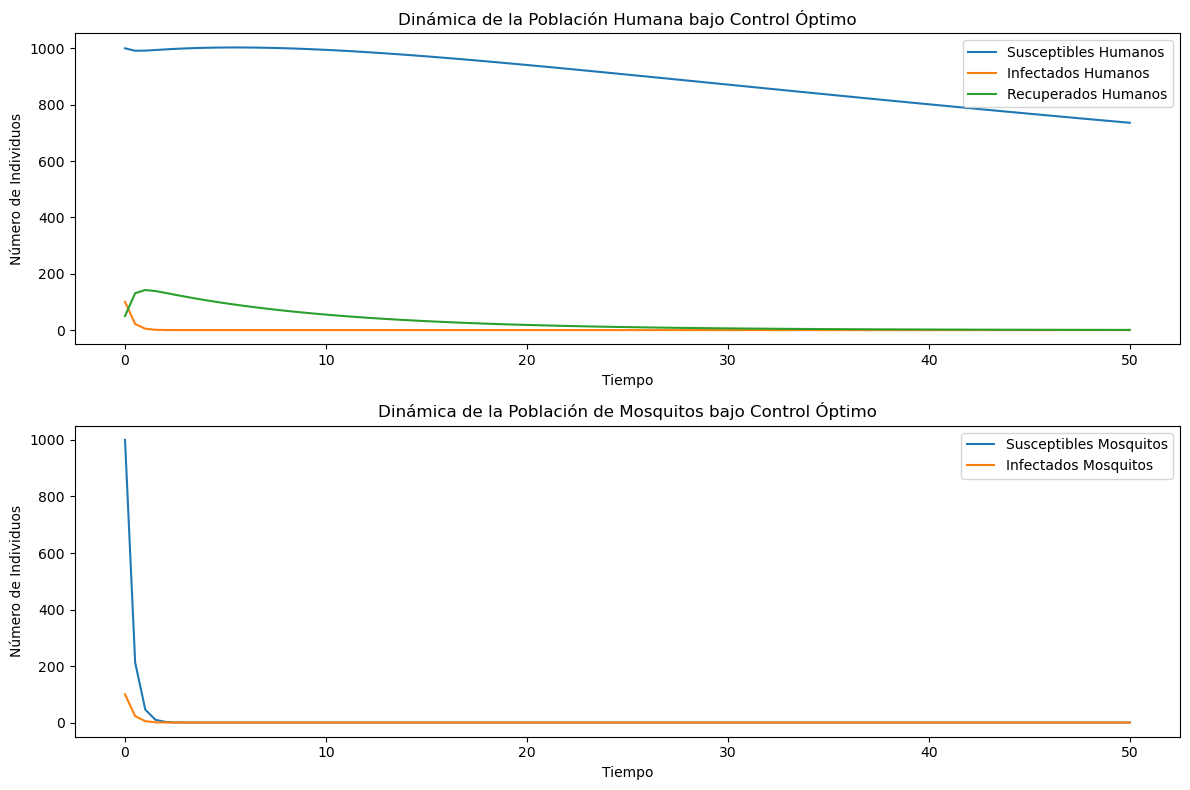

In [15]:
import matplotlib.pyplot as plt

# Función para simular el sistema con el control óptimo
def simulate_system(u, initial_conditions, params, T):
    result = solve_ivp(lambda t, y: sistema_dinamico(t, y, u, params), [0, T], initial_conditions, t_eval=np.linspace(0, T, 100))
    return result.t, result.y

# Valor óptimo de u encontrado
optimal_u = solucion.x[0]

# Simular el sistema con el valor óptimo de u
t, y = simulate_system(optimal_u, initial_conditions, params, T)

# Descomponer los resultados en poblaciones específicas
Sh, Ih, Rh, Sv, Iv = y

# Crear gráficos
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, Sh, label='Susceptibles Humanos')
plt.plot(t, Ih, label='Infectados Humanos')
plt.plot(t, Rh, label='Recuperados Humanos')
plt.title('Dinámica de la Población Humana bajo Control Óptimo')
plt.xlabel('Tiempo')
plt.ylabel('Número de Individuos')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, Sv, label='Susceptibles Mosquitos')
plt.plot(t, Iv, label='Infectados Mosquitos')
plt.title('Dinámica de la Población de Mosquitos bajo Control Óptimo')
plt.xlabel('Tiempo')
plt.ylabel('Número de Individuos')
plt.legend()

plt.tight_layout()
plt.show()